Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 760 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 375 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.5707 - loss: 0.8465 - val_accuracy: 0.8177 - val_loss: 0.5919 - learning_rate: 0.0010
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.7015 - loss: 0.5931 - val_accuracy: 0.8122 - val_loss: 0.4792 - learning_rate: 0.0010
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 178s 8s/step - accuracy: 0.7771 - loss: 0.4666 - val_accuracy: 0.8011 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 207s 9s/step - accuracy: 0.8012 - loss: 0.4347 - val_accuracy: 0.8039 - val_loss: 0.3945 - learning_rate: 0.0010
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 180s 8s/step - accuracy: 0.8001 - loss: 0.4324 - val_accuracy: 0.7983 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.8257 - loss: 0.3902 - val_accuracy: 0.8177 - val_loss: 0.3589 - learning_rate: 0.0010
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.8652 - loss: 0.3306 - val_acc

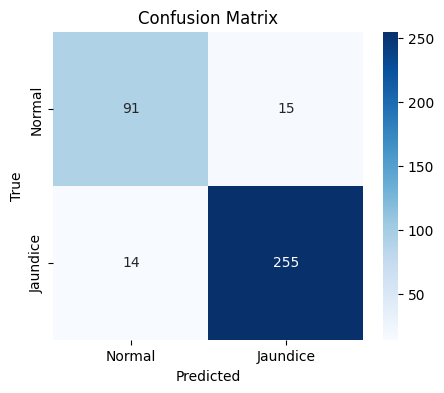

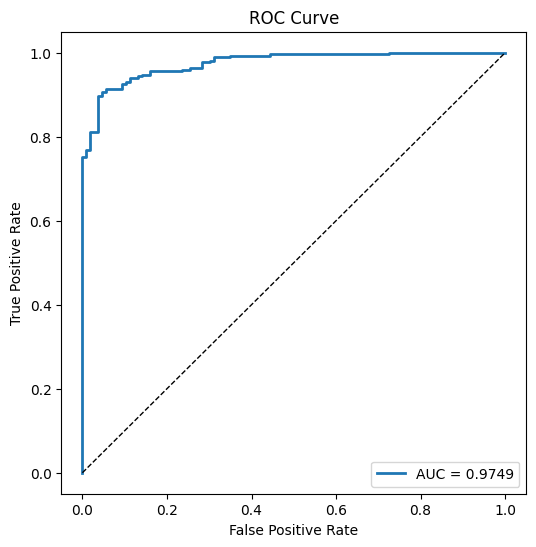

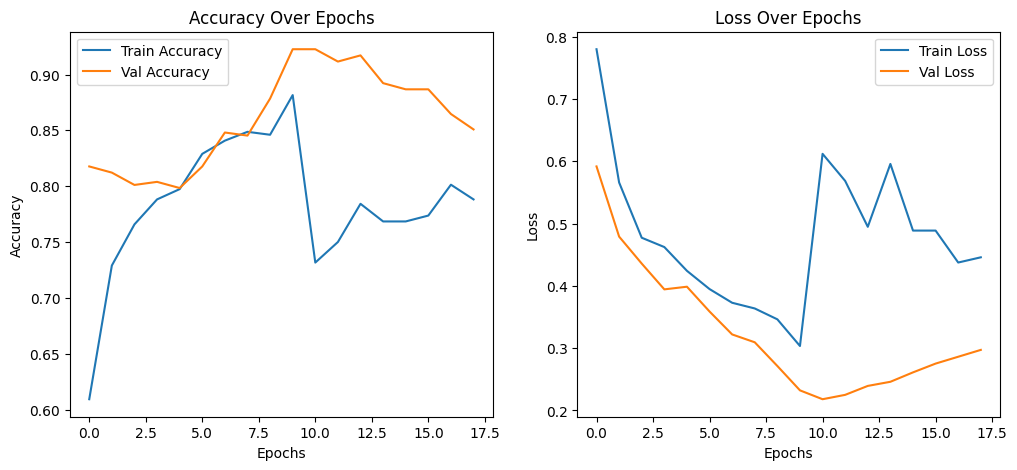

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import Required Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set Paths
base_dir = "/content/drive/MyDrive/Project 5: Jaundice Tracker/jaundice_dataset/jaundice_preprocessed"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Image Parameters
target_size = (224, 224)  # EfficientNetB3 input size
batch_size = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=25, # Increased
    width_shift_range=0.3, # Increased
    height_shift_range=0.3, # Increased
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator()

# Load Images Directly From Folders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

# Load EfficientNetB3 Model (Without Top Layers)
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable= False # Freeze Base Model Initially

# Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)  # Reduced dropout rate
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation="sigmoid")(x)  # Ensure 'x' is passed into the layer, Binary Classification

# Create Final Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model (Initial Training)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
# Callbacks for Learning Rate Adjustment
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Train Model (Initial Phase w/ Frozen Base Model)
history = model.fit(
    train_generator,
    epochs=10, # Increased training epochs
    validation_data=val_generator,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

# Gradual Unfreezing for Fine-Tuning
for layer in base_model.layers[:150]: # Keep first 150 layers frozen initially
  layer.trainable = False
for layer in base_model.layers[150:]: # Unfreeze last 50 layers
  layer.trainable = True

# Compile Model with Lower Learning Rate for Fine-Tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower LR for Fine-Tuning
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
# Continue Training (Fine-Tuning Phase)
history_finetune = model.fit(
    train_generator,
    epochs=15, # Fine Tuning Phase
    validation_data=val_generator,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

# Save Model to Google Drive
model_save_path = "/content/drive/MyDrive/jaundice_detection_modelv2.keras"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

# Evaluate Model
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

# Get True Labels from Generator
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)

# Display results as a table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    "Value" : [accuracy,precision,recall,f1,auc]
})
print("\nFinal Test Results:\n")
print(metrics_df.to_string(index=False))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Jaundice"], yticklabels=["Normal", "Jaundice"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true,y_pred_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label=f"AUC = {auc:.4f}", linewidth=2)
plt.plot([0,1],[0,1], 'k--', linewidth=1) # Random Classifier Line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")


plt.subplot(1, 2, 2)
train_loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()